# Measurements Reindexing Mainnet

These measurements were made on a full node on GCP (Google Compute) reindexing mainnet.

The host is type `n1-standard-1` which means:
 * 1 virtual CPU (pinned to the host CPU)
 * 4096 MB of RAM, of which about 3.6 GB is available to userspace
 * Very slow disks (connected to some kind of SAN)
 
Bitcoin itself is configured with `dbcache=2048`.

## Motivation

The motivation here is to make IBD work better on machines with slow disks. For instance, on most cloud instances IBD will be extremely I/O bound, to the point that it's basically impossible to actually finish syncing a node. This is true even on hosts that have a relatively large amount of memory, and therefore ought to be able ot keep most of the dataset in memory.

## A Priori Memory Predictions

How much memory would we expect the UTXO set to use if it was fully loaded into memory? We can calculate this with the size of keys/values and the number of entries in the UTXO set.

Even on hosts that don't have this much memory for their dbcache, hosts that have a reasonable proportion of that memory (e.g. 50% of it) ought to see a big speedup.

In [12]:
coutpoint_size = 36  # sizeof(COutPoint)
cache_entry_size = 56  # sizeof(CCoinsCacheEntry)
current_utxo_size = 57.3e6  # approximate number of entries in the current uxto set
estimated_map_size = (coutpoint_size + cache_entry_size) * current_utxo_size
print('Estimated memory: {:1.2f} GB'.format(estimated_map_size / (1<<30)))

Estimated memory: 4.91 GB


Note that this estimate assumes no overhead for the space taken by the hash table itself. Therefore we should consider it a lower bound on the amount of memory that would be needed. Given a properly tuned hash table though the real world results shouldn't take that much more memory.

## Measurements

In [13]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd

matplotlib.rcParams['figure.dpi']= 300
matplotlib.rcParams['figure.figsize'] = [12, 8]

In [14]:
# this loads the local file unpack.py, force reloading it if necessary
import importlib
import sys
try:
    importlib.reload(sys.modules['unpack'])
    importlib.reload(sys.modules['plotutils'])
except KeyError:
    import unpack
    import plotutils

# set these as aliases this weird way to handle reloading
plot = plotutils.plot
select = plotutils.select

# load the data and print some information about it
data = unpack.unpack_data('bitcoin-core')

print()
print('Host Info')
print('---------')
for k, v in data['hostinfo'].items():
    print('{:16s}{}'.format(k, v))

frames = data['frames']
print()
print('Data Frames')
print('-----------')
print(' '.join(sorted(frames.keys())))

# naughty
globals().update(frames)

Loading data from input file /home/evan/logs/bitcoin-core-1518996011.log

Host Info
---------
date            2018-02-18T23:20:11+00:00
hostname        bitcoin-core
uname           4.14.18-300.fc27.x86_64
memtotal        3871977472
fdlimit         4096
git:commit      852f0f91252bb1913a982fa5cf3d40ef4283b83a
git:branch      probes

Data Frames
-----------
bio cache flushes leveldb memory updatetip vfs


In [15]:
# List of all flush events that happened
plotutils.set_flushes(flushes)
flushes.head()

,coins:bytes,coins:count
2018-02-18 19:05:00.947396,2437160176,16892384
2018-02-18 23:30:21.062918,2437527728,16921733


### Indexing Rate (Height)

In this section we'll look at how fast the chain is syncing, measured by the chain height.

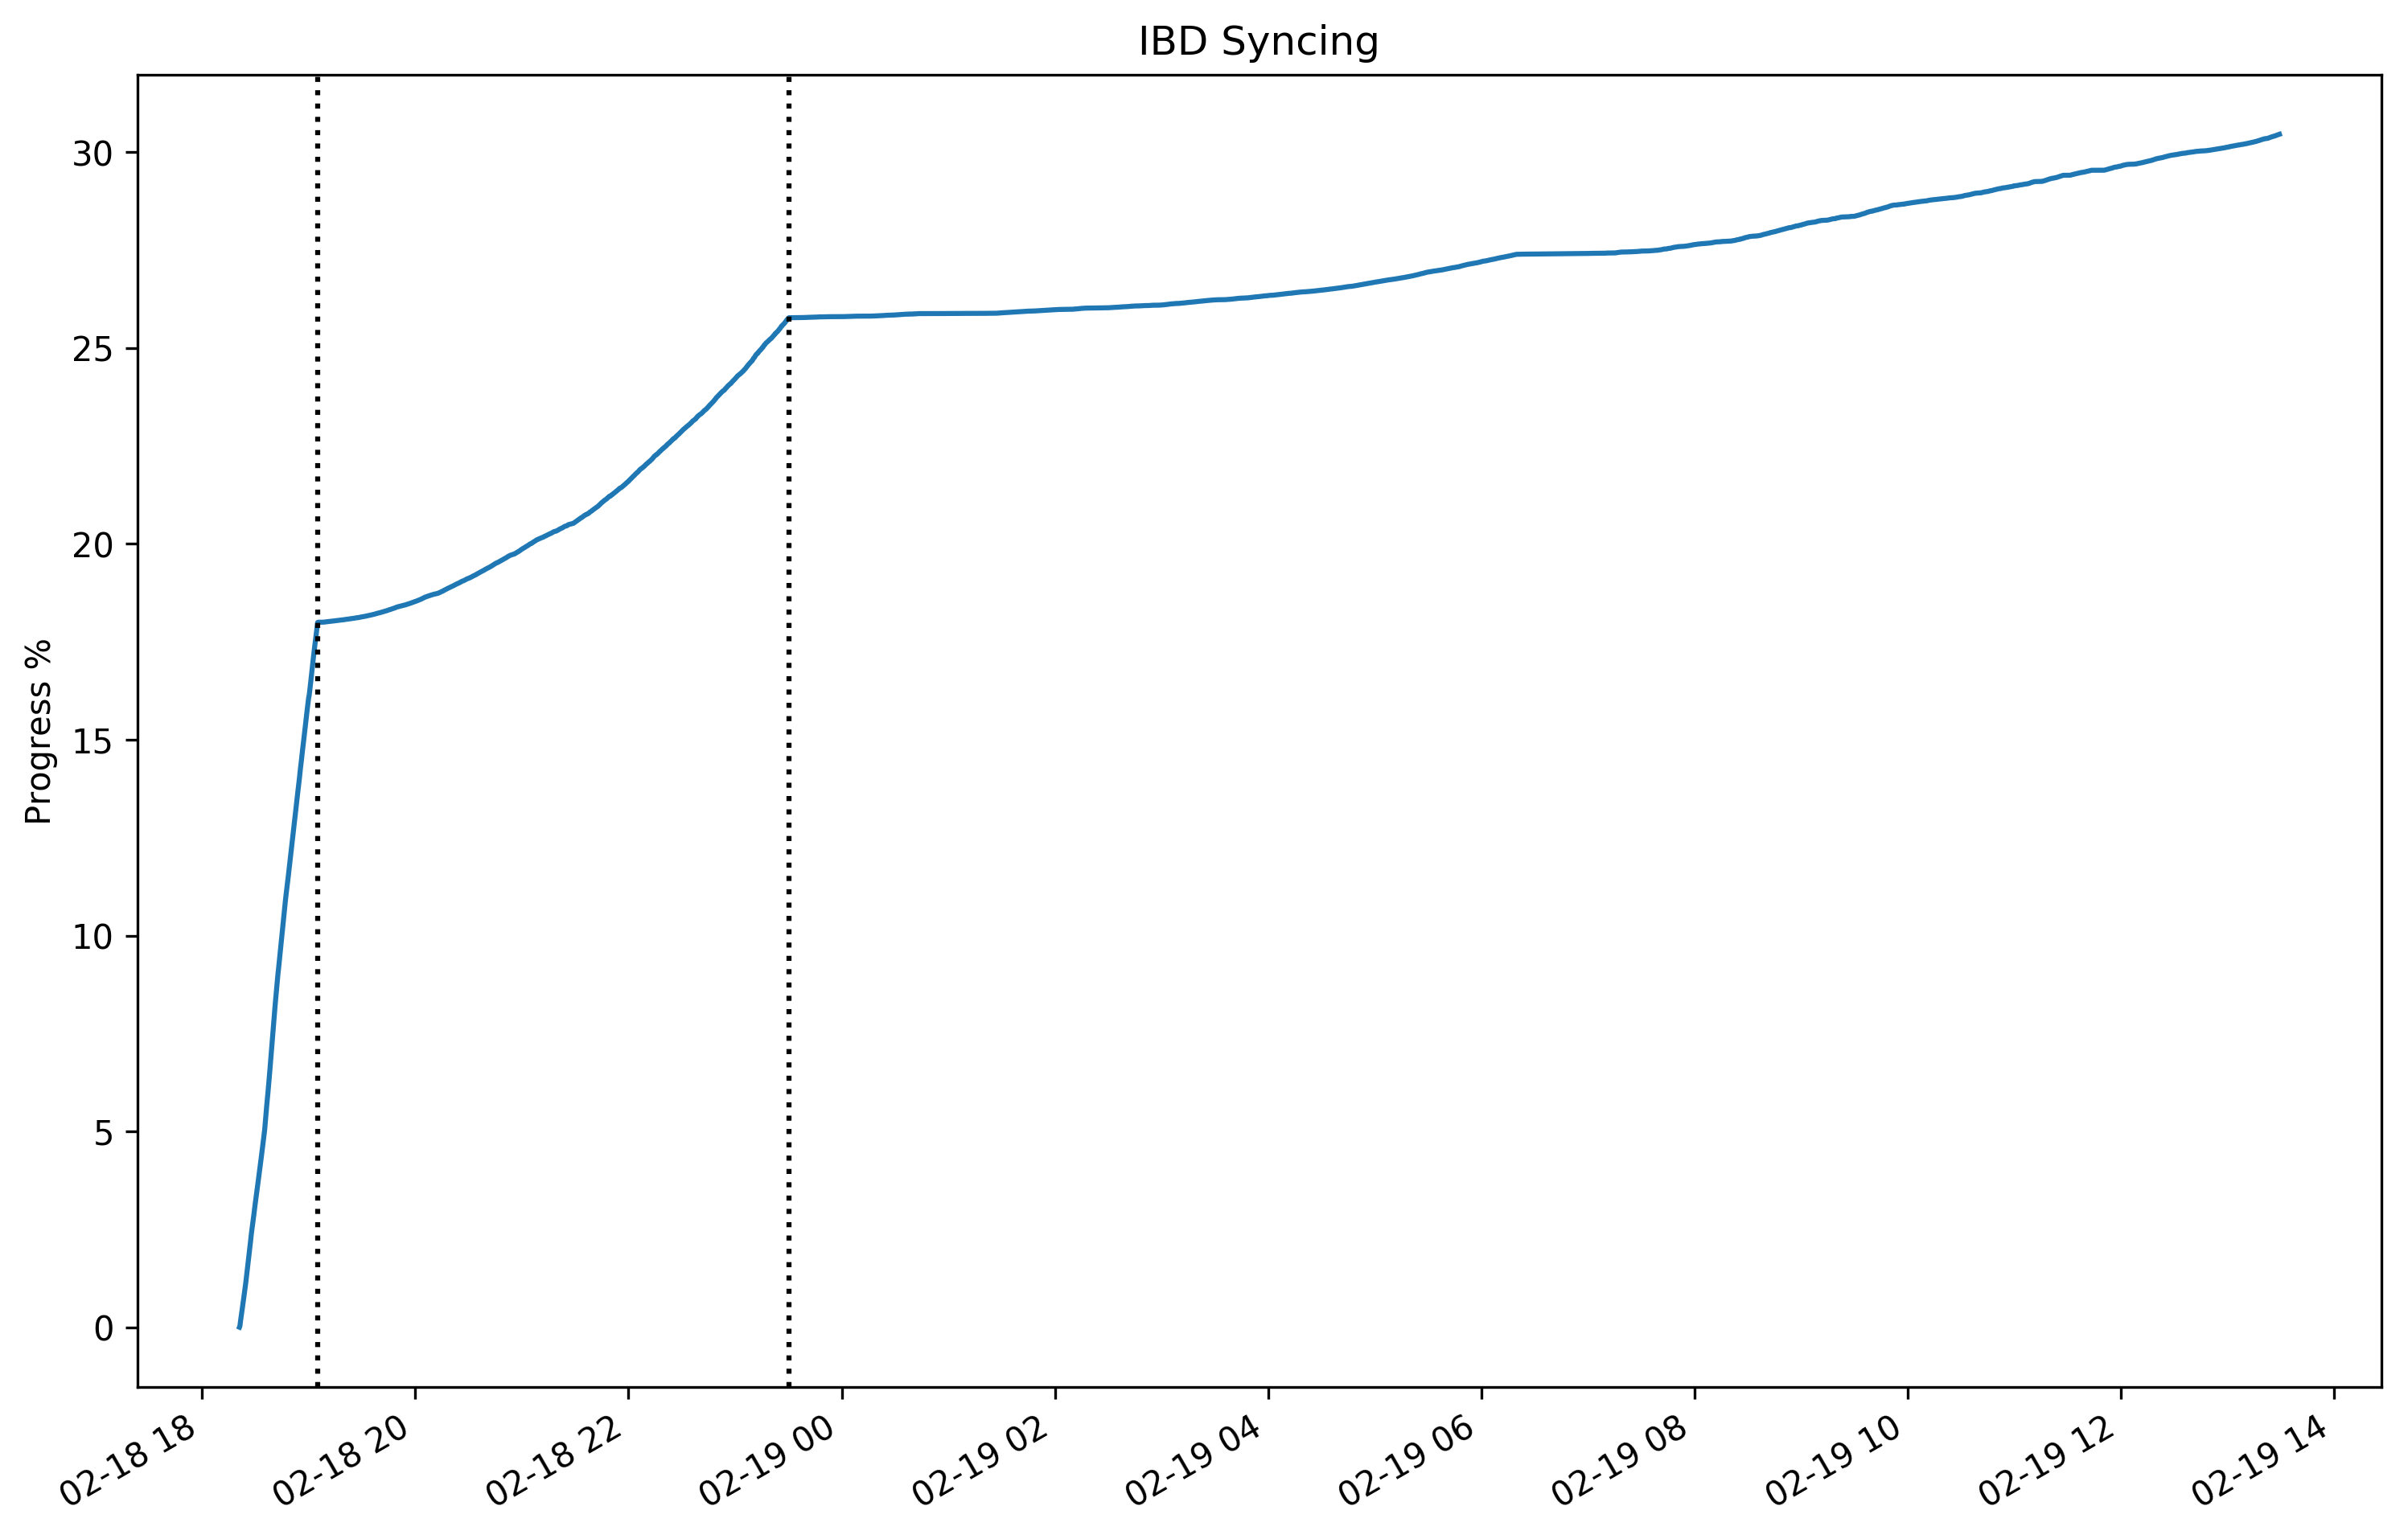

In [16]:
#df = updatetip[['height', 'progress']]
#plot(df, title='Progress', secondary_y=['progress'])
plot(updatetip['progress'] * 100, title='IBD Syncing', ylabel='Progress %')

### Cache Hits

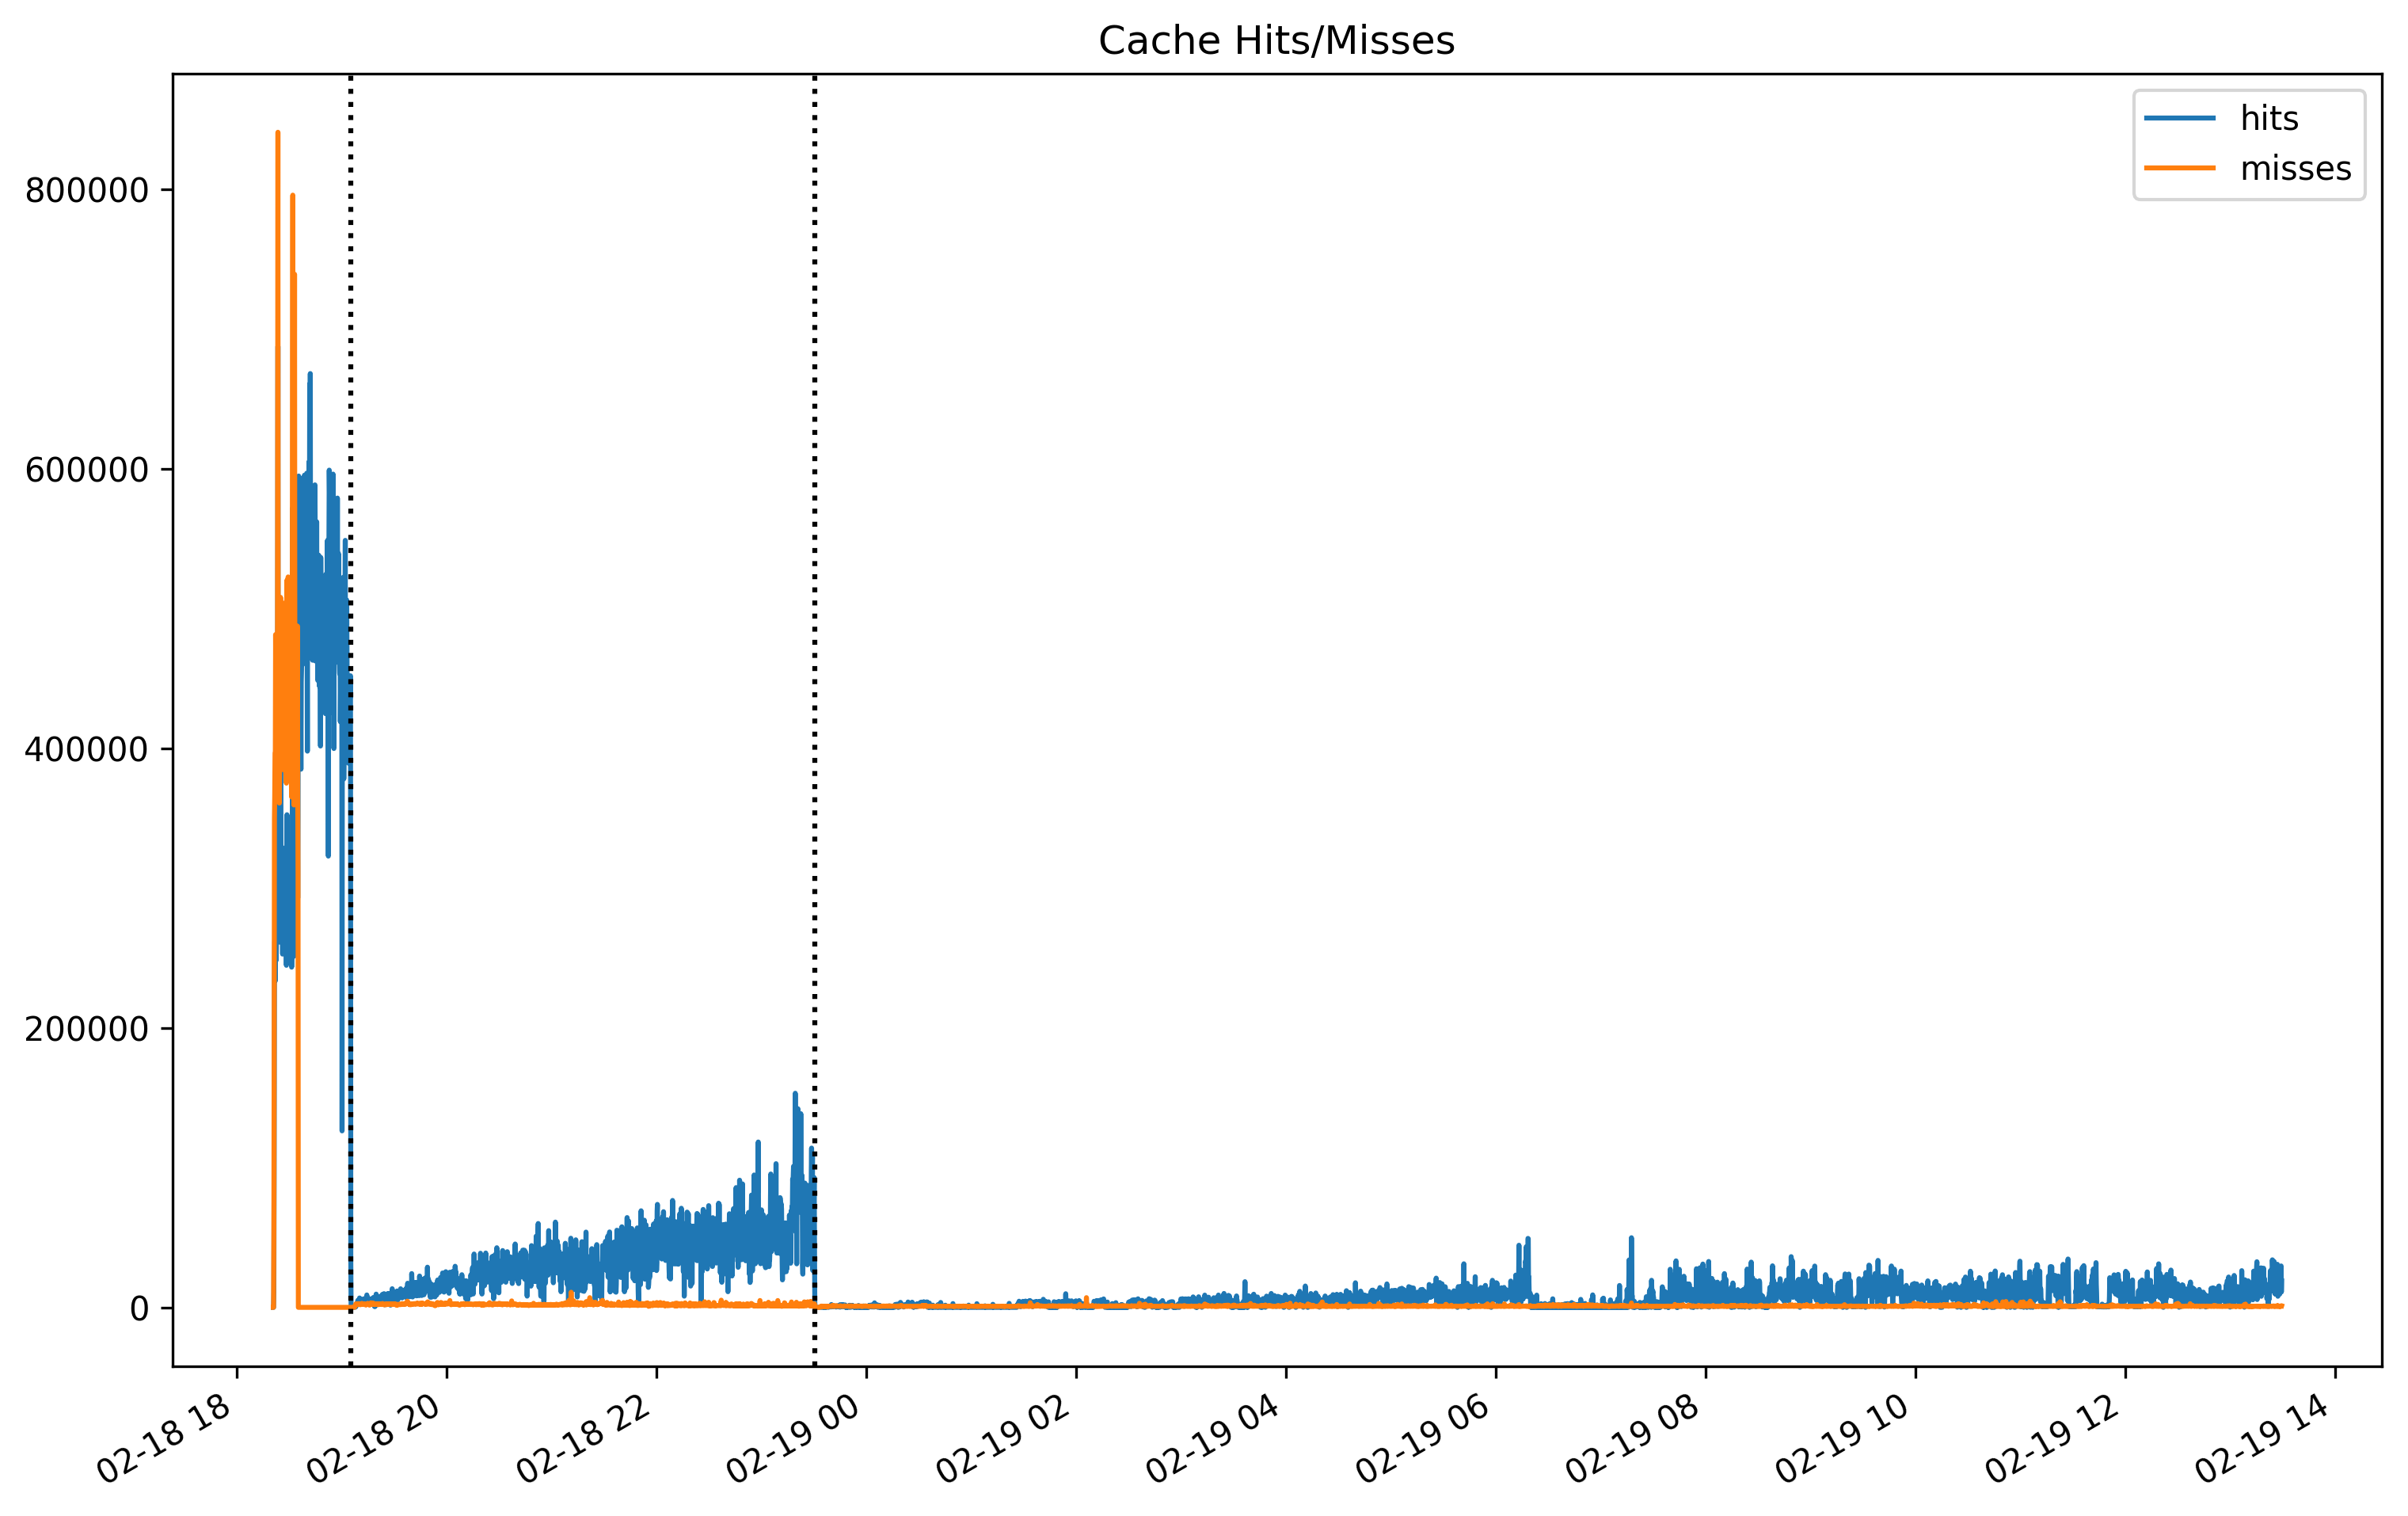

In [17]:
plot(cache, title='Cache Hits/Misses')

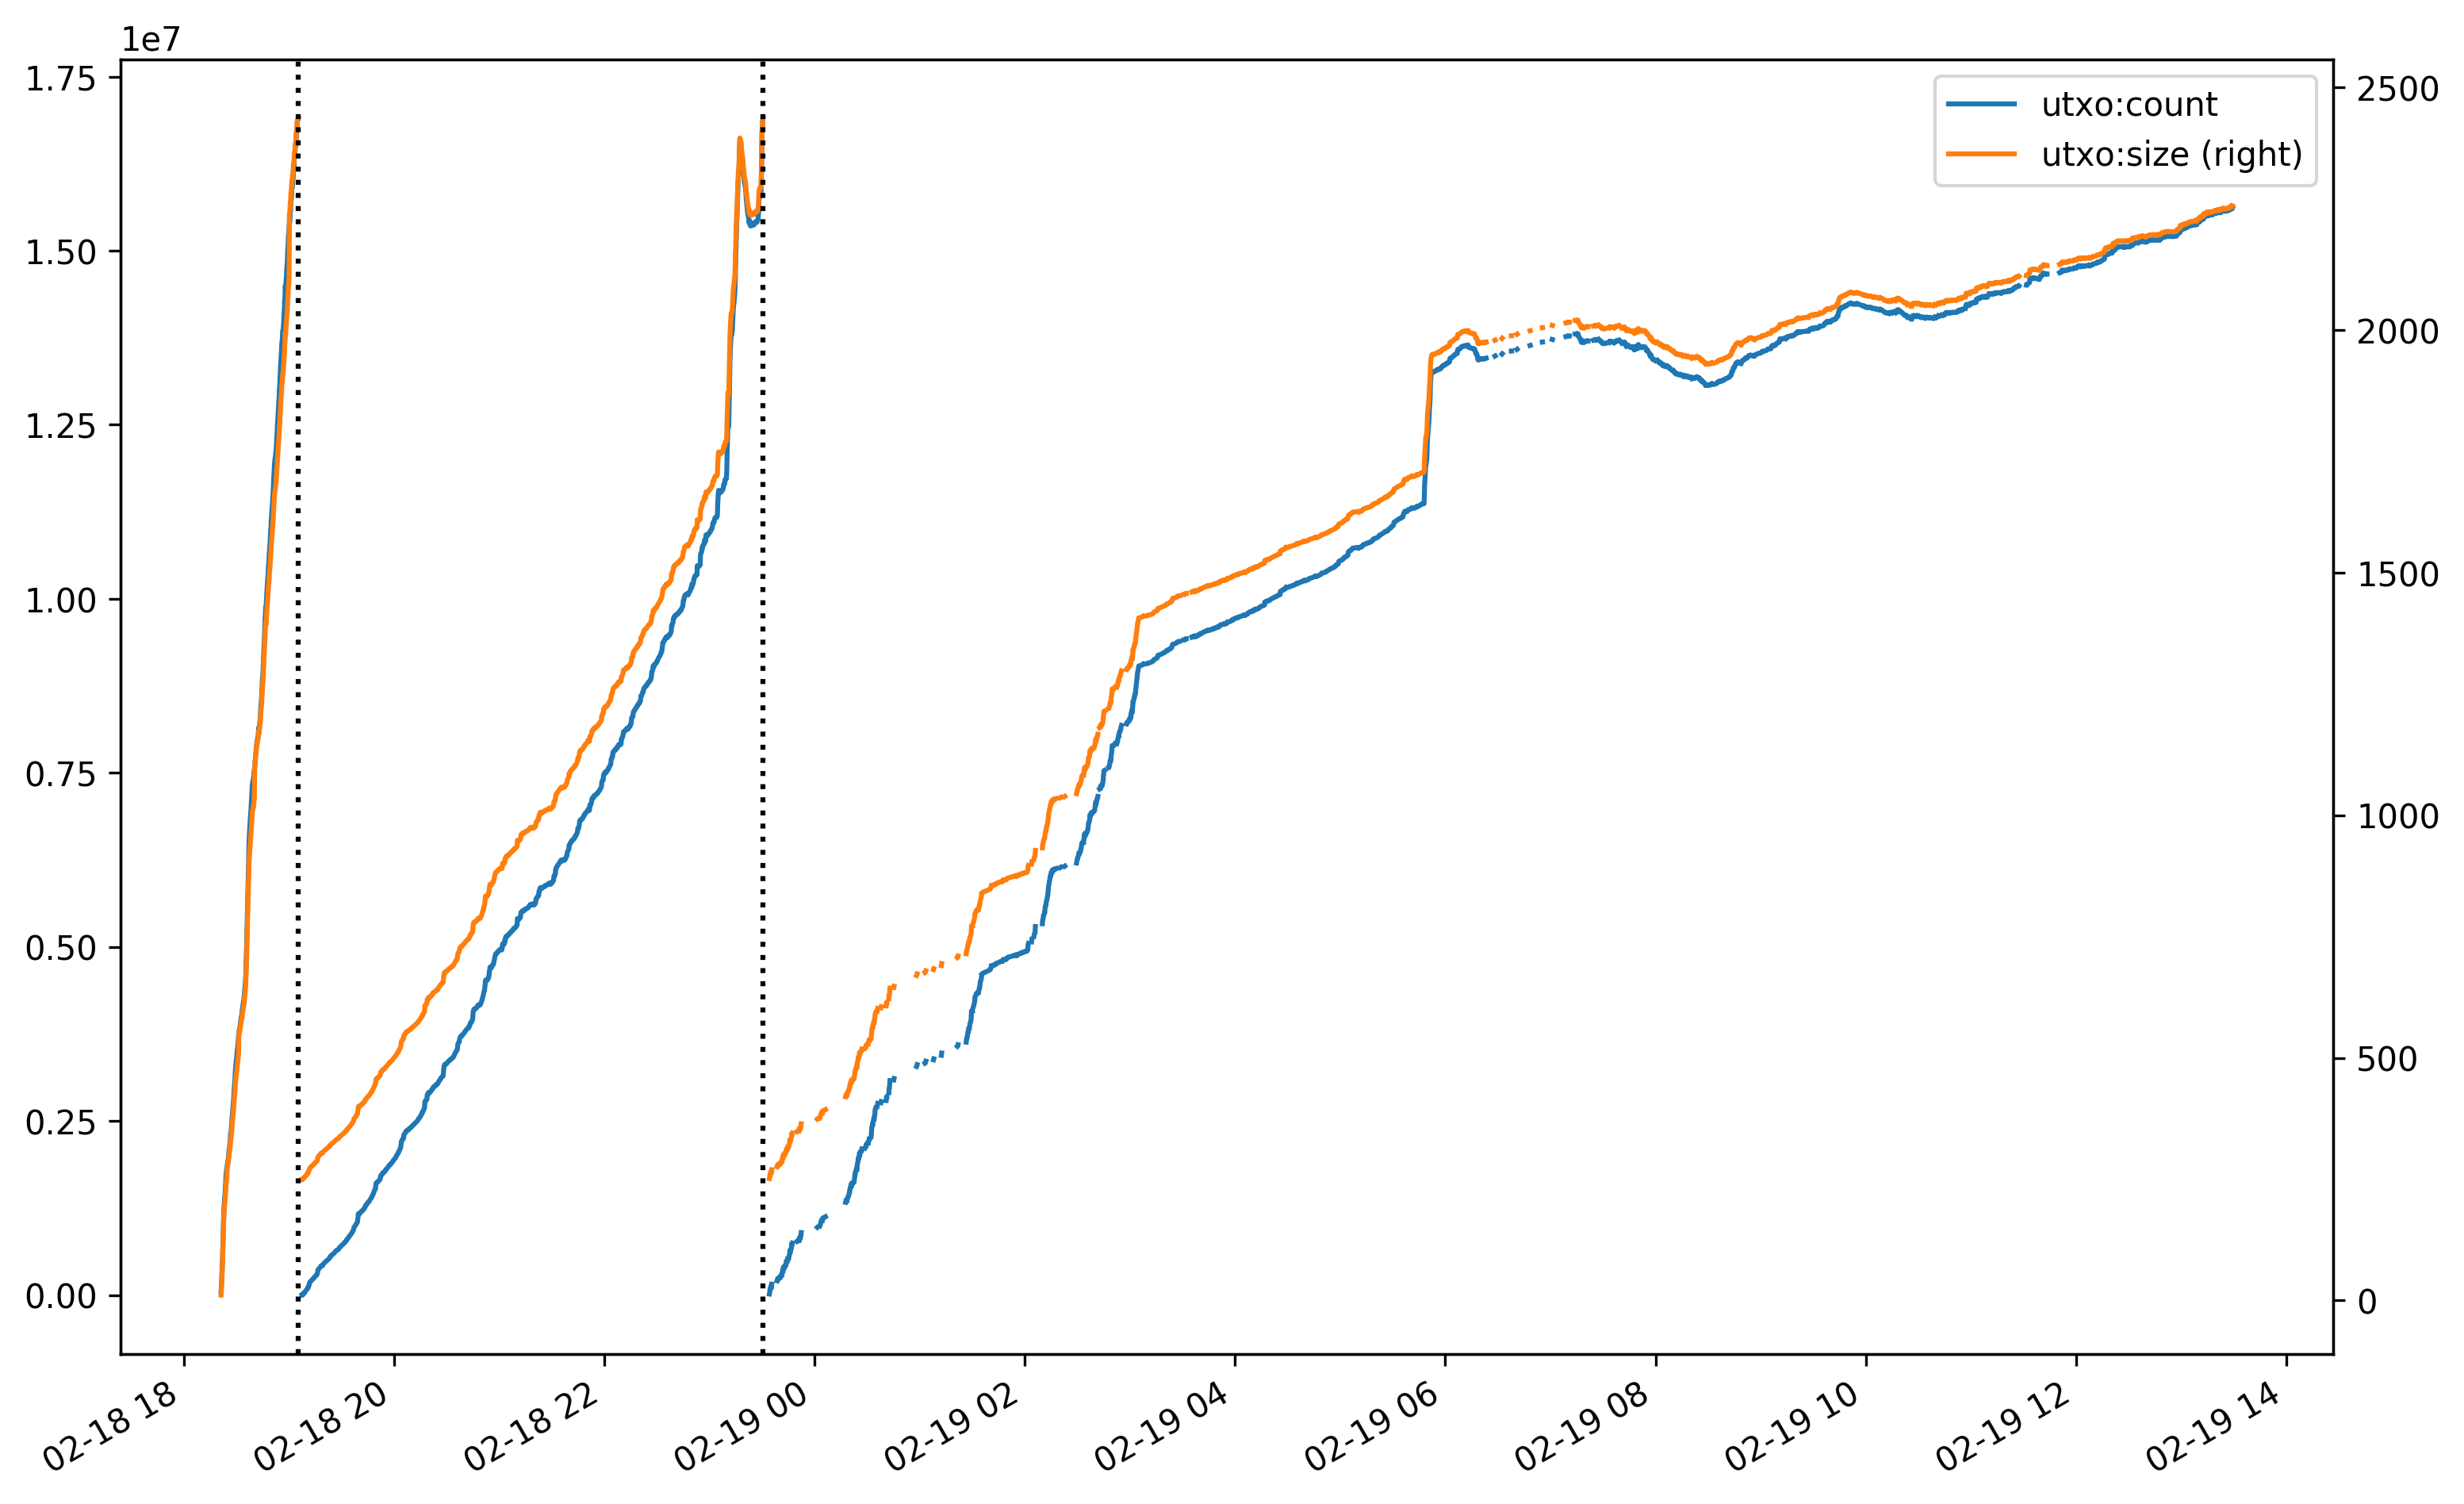

In [18]:
df = updatetip.copy()
df['utxo:size'] /= 1e6
plot(df[['utxo:count', 'utxo:size']], secondary_y=['utxo:size'])

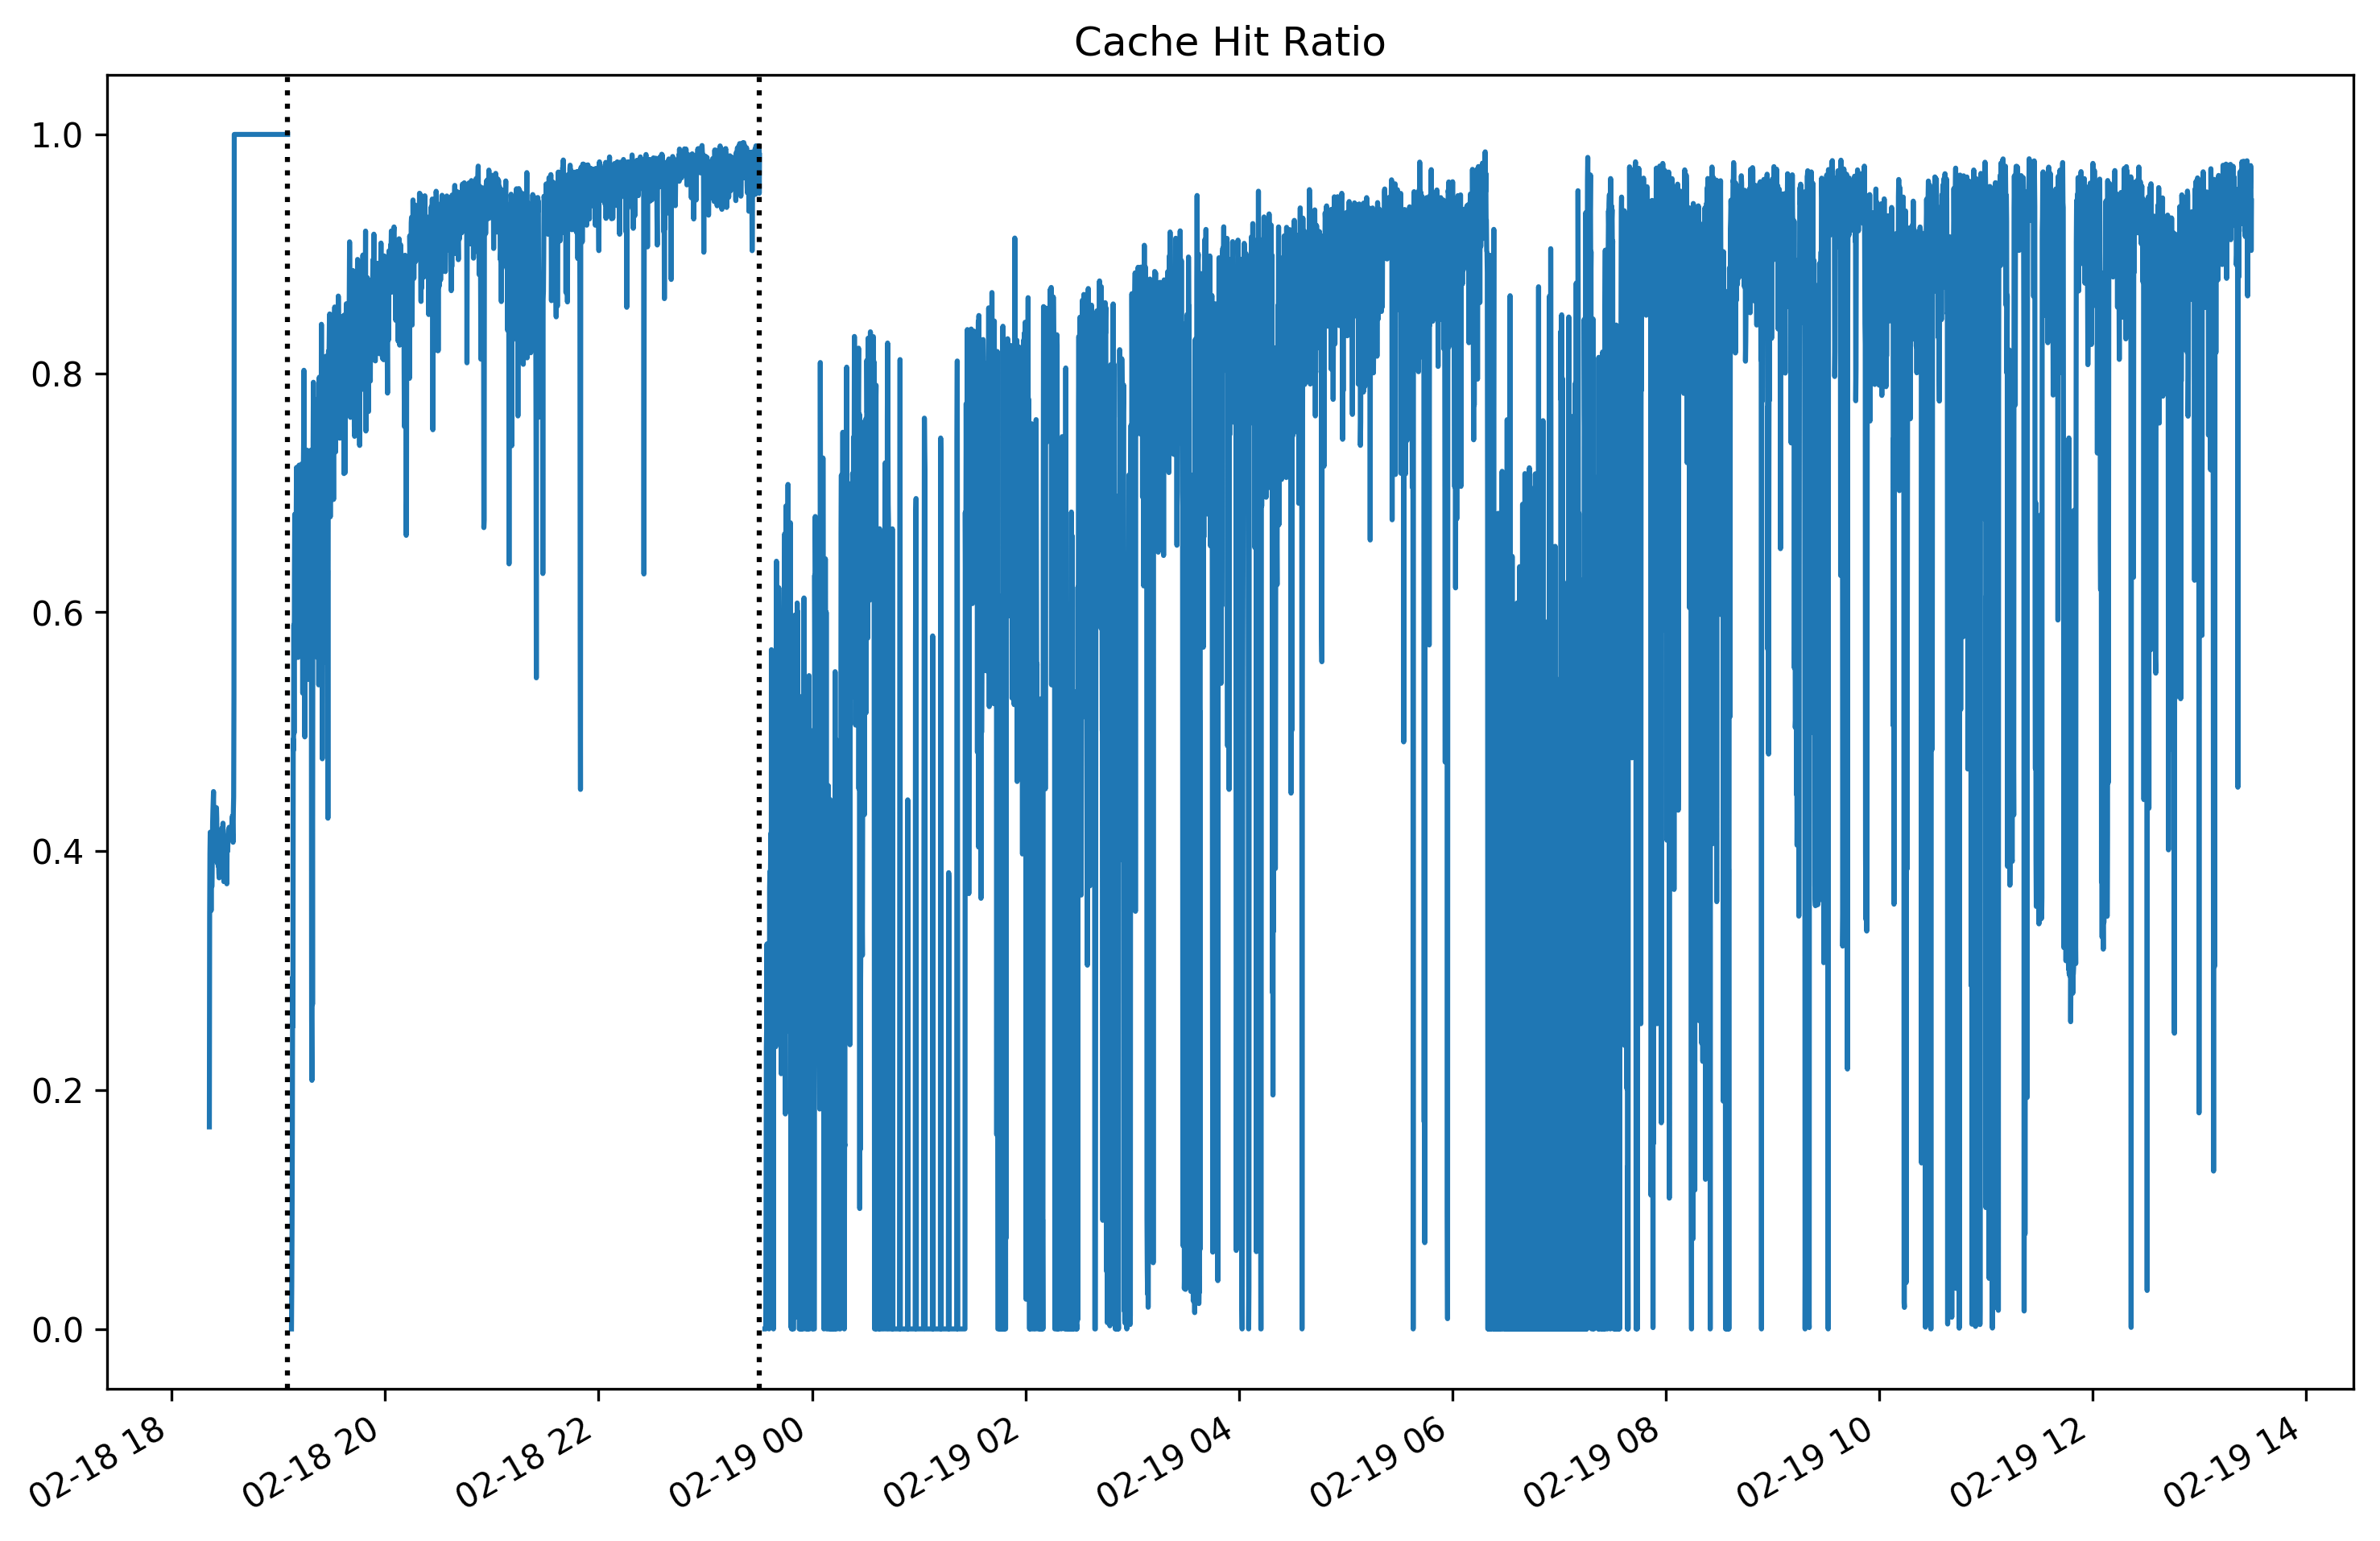

In [19]:
hits = cache['hits']
total = hits + cache['misses']
plot(hits / total, title='Cache Hit Ratio')

## Disk / VFS Stats

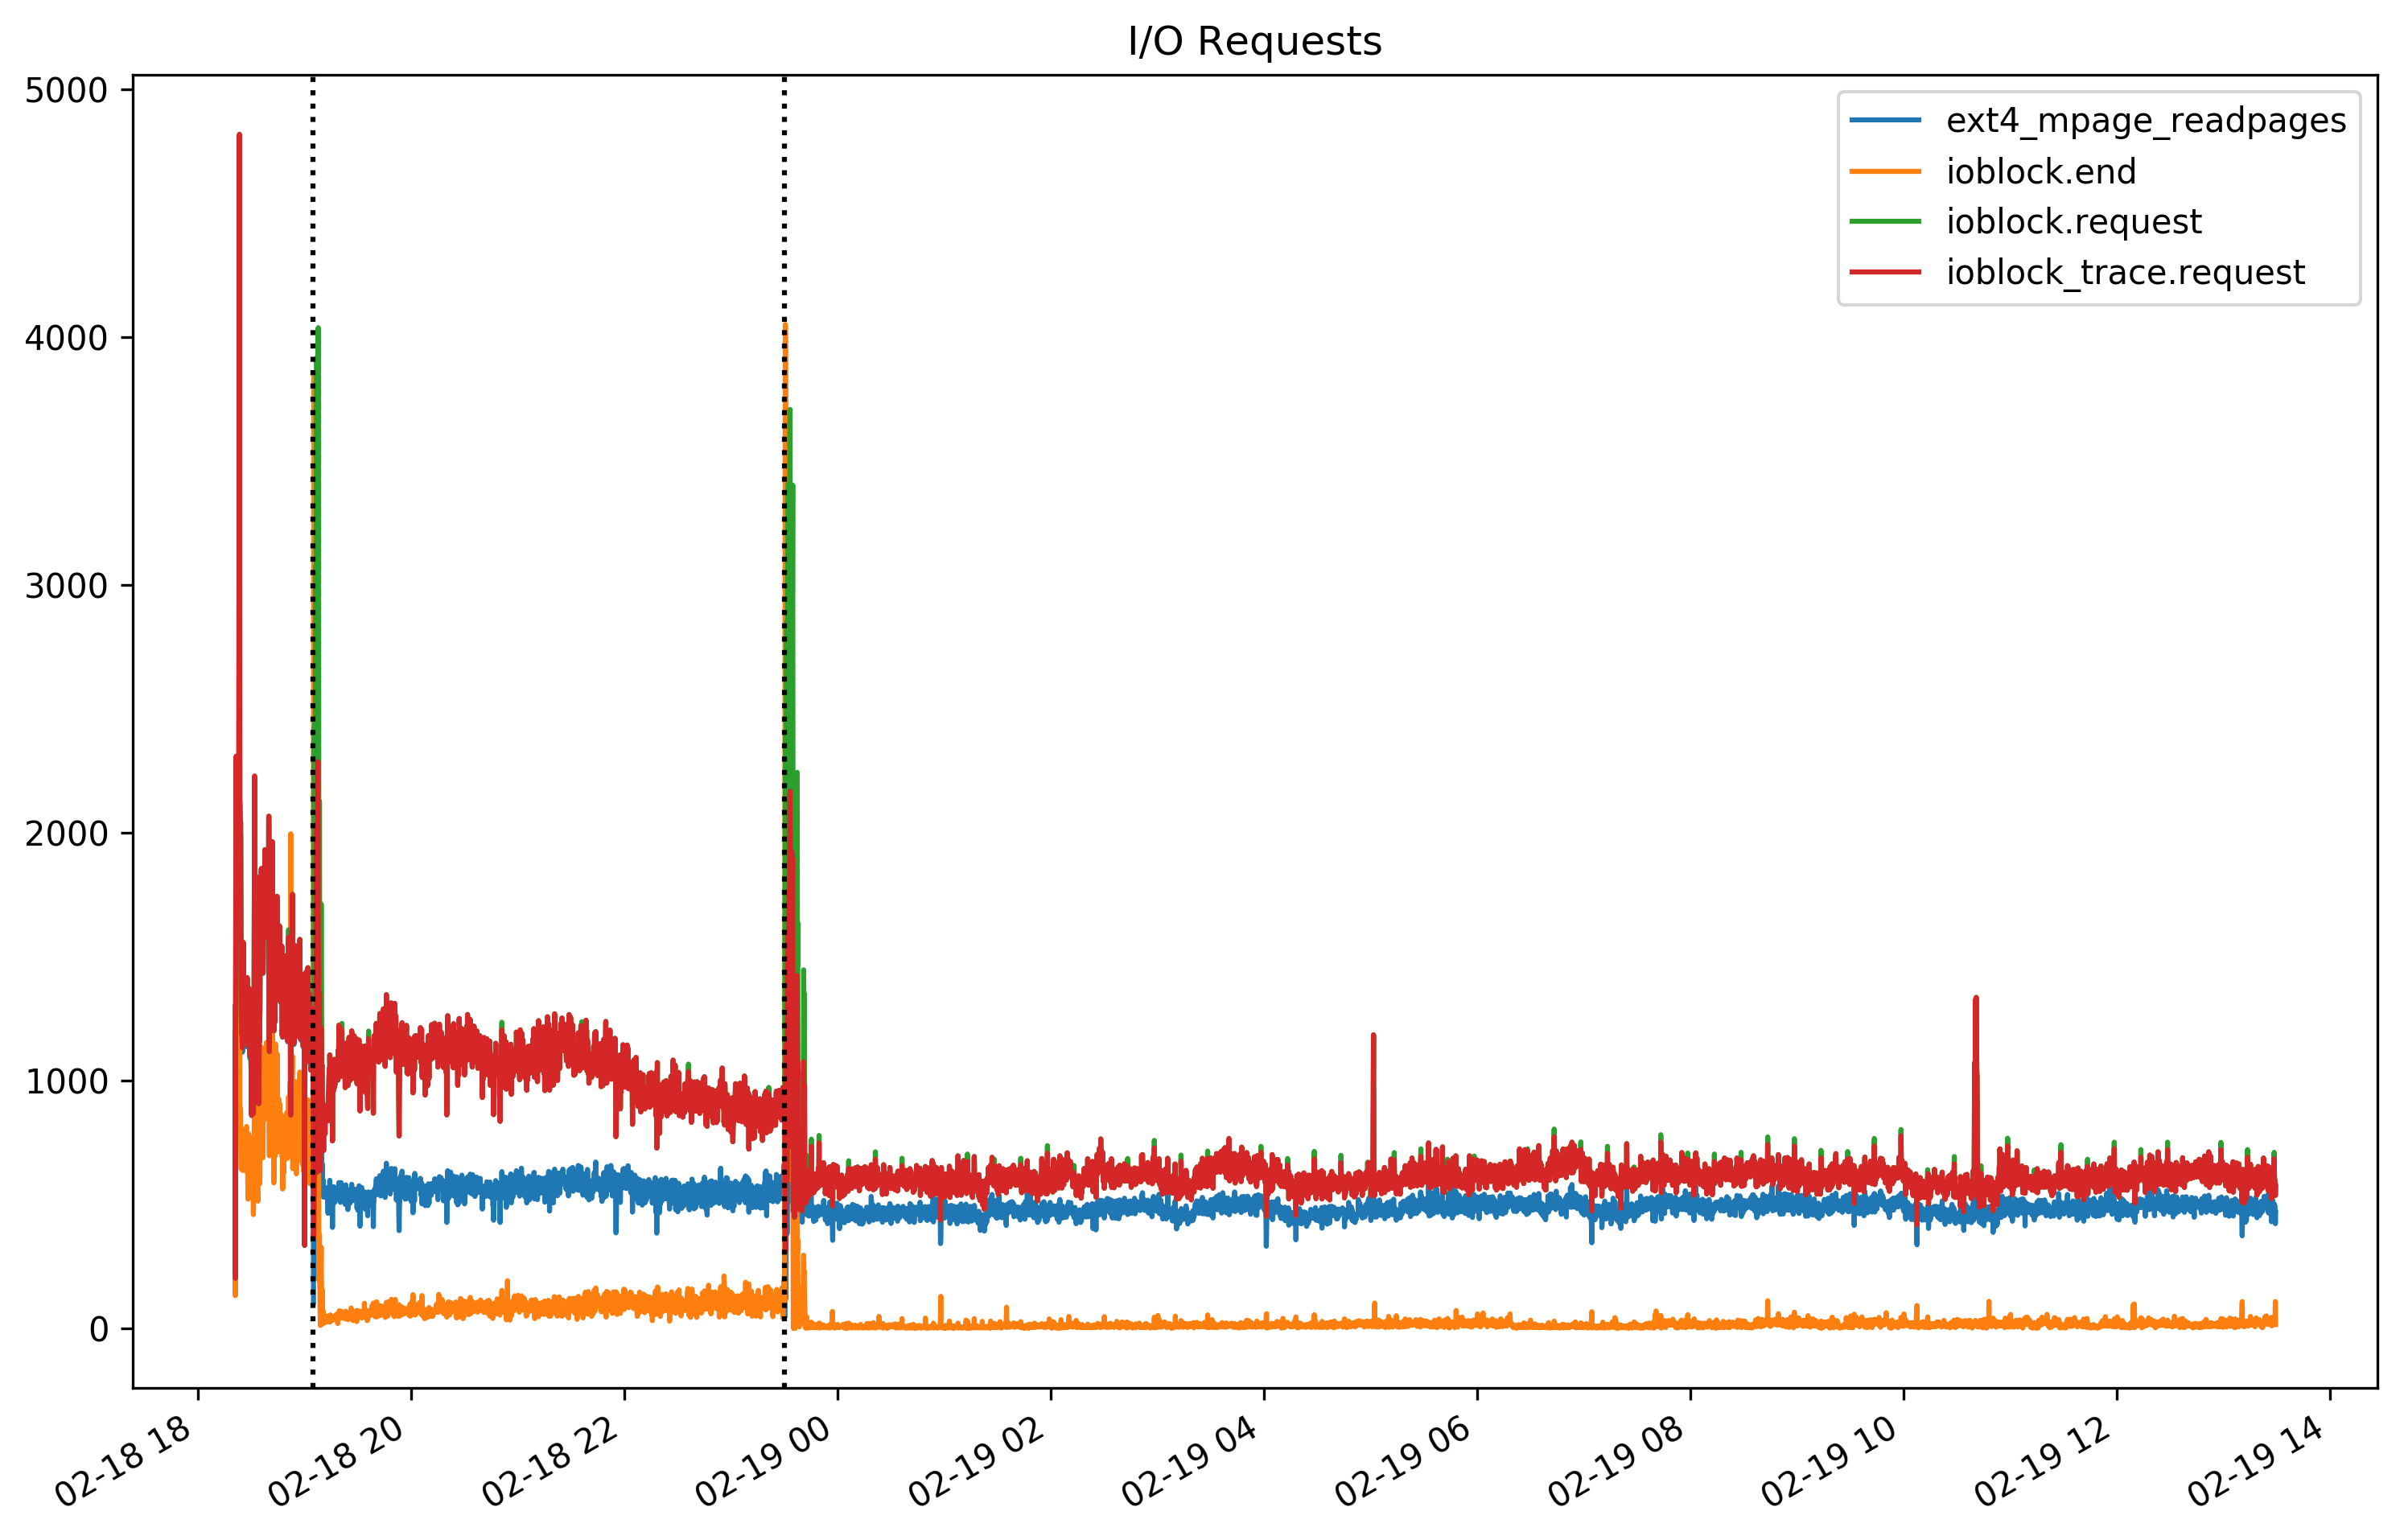

In [20]:
plot(select(bio, 'count'), title='I/O Requests')

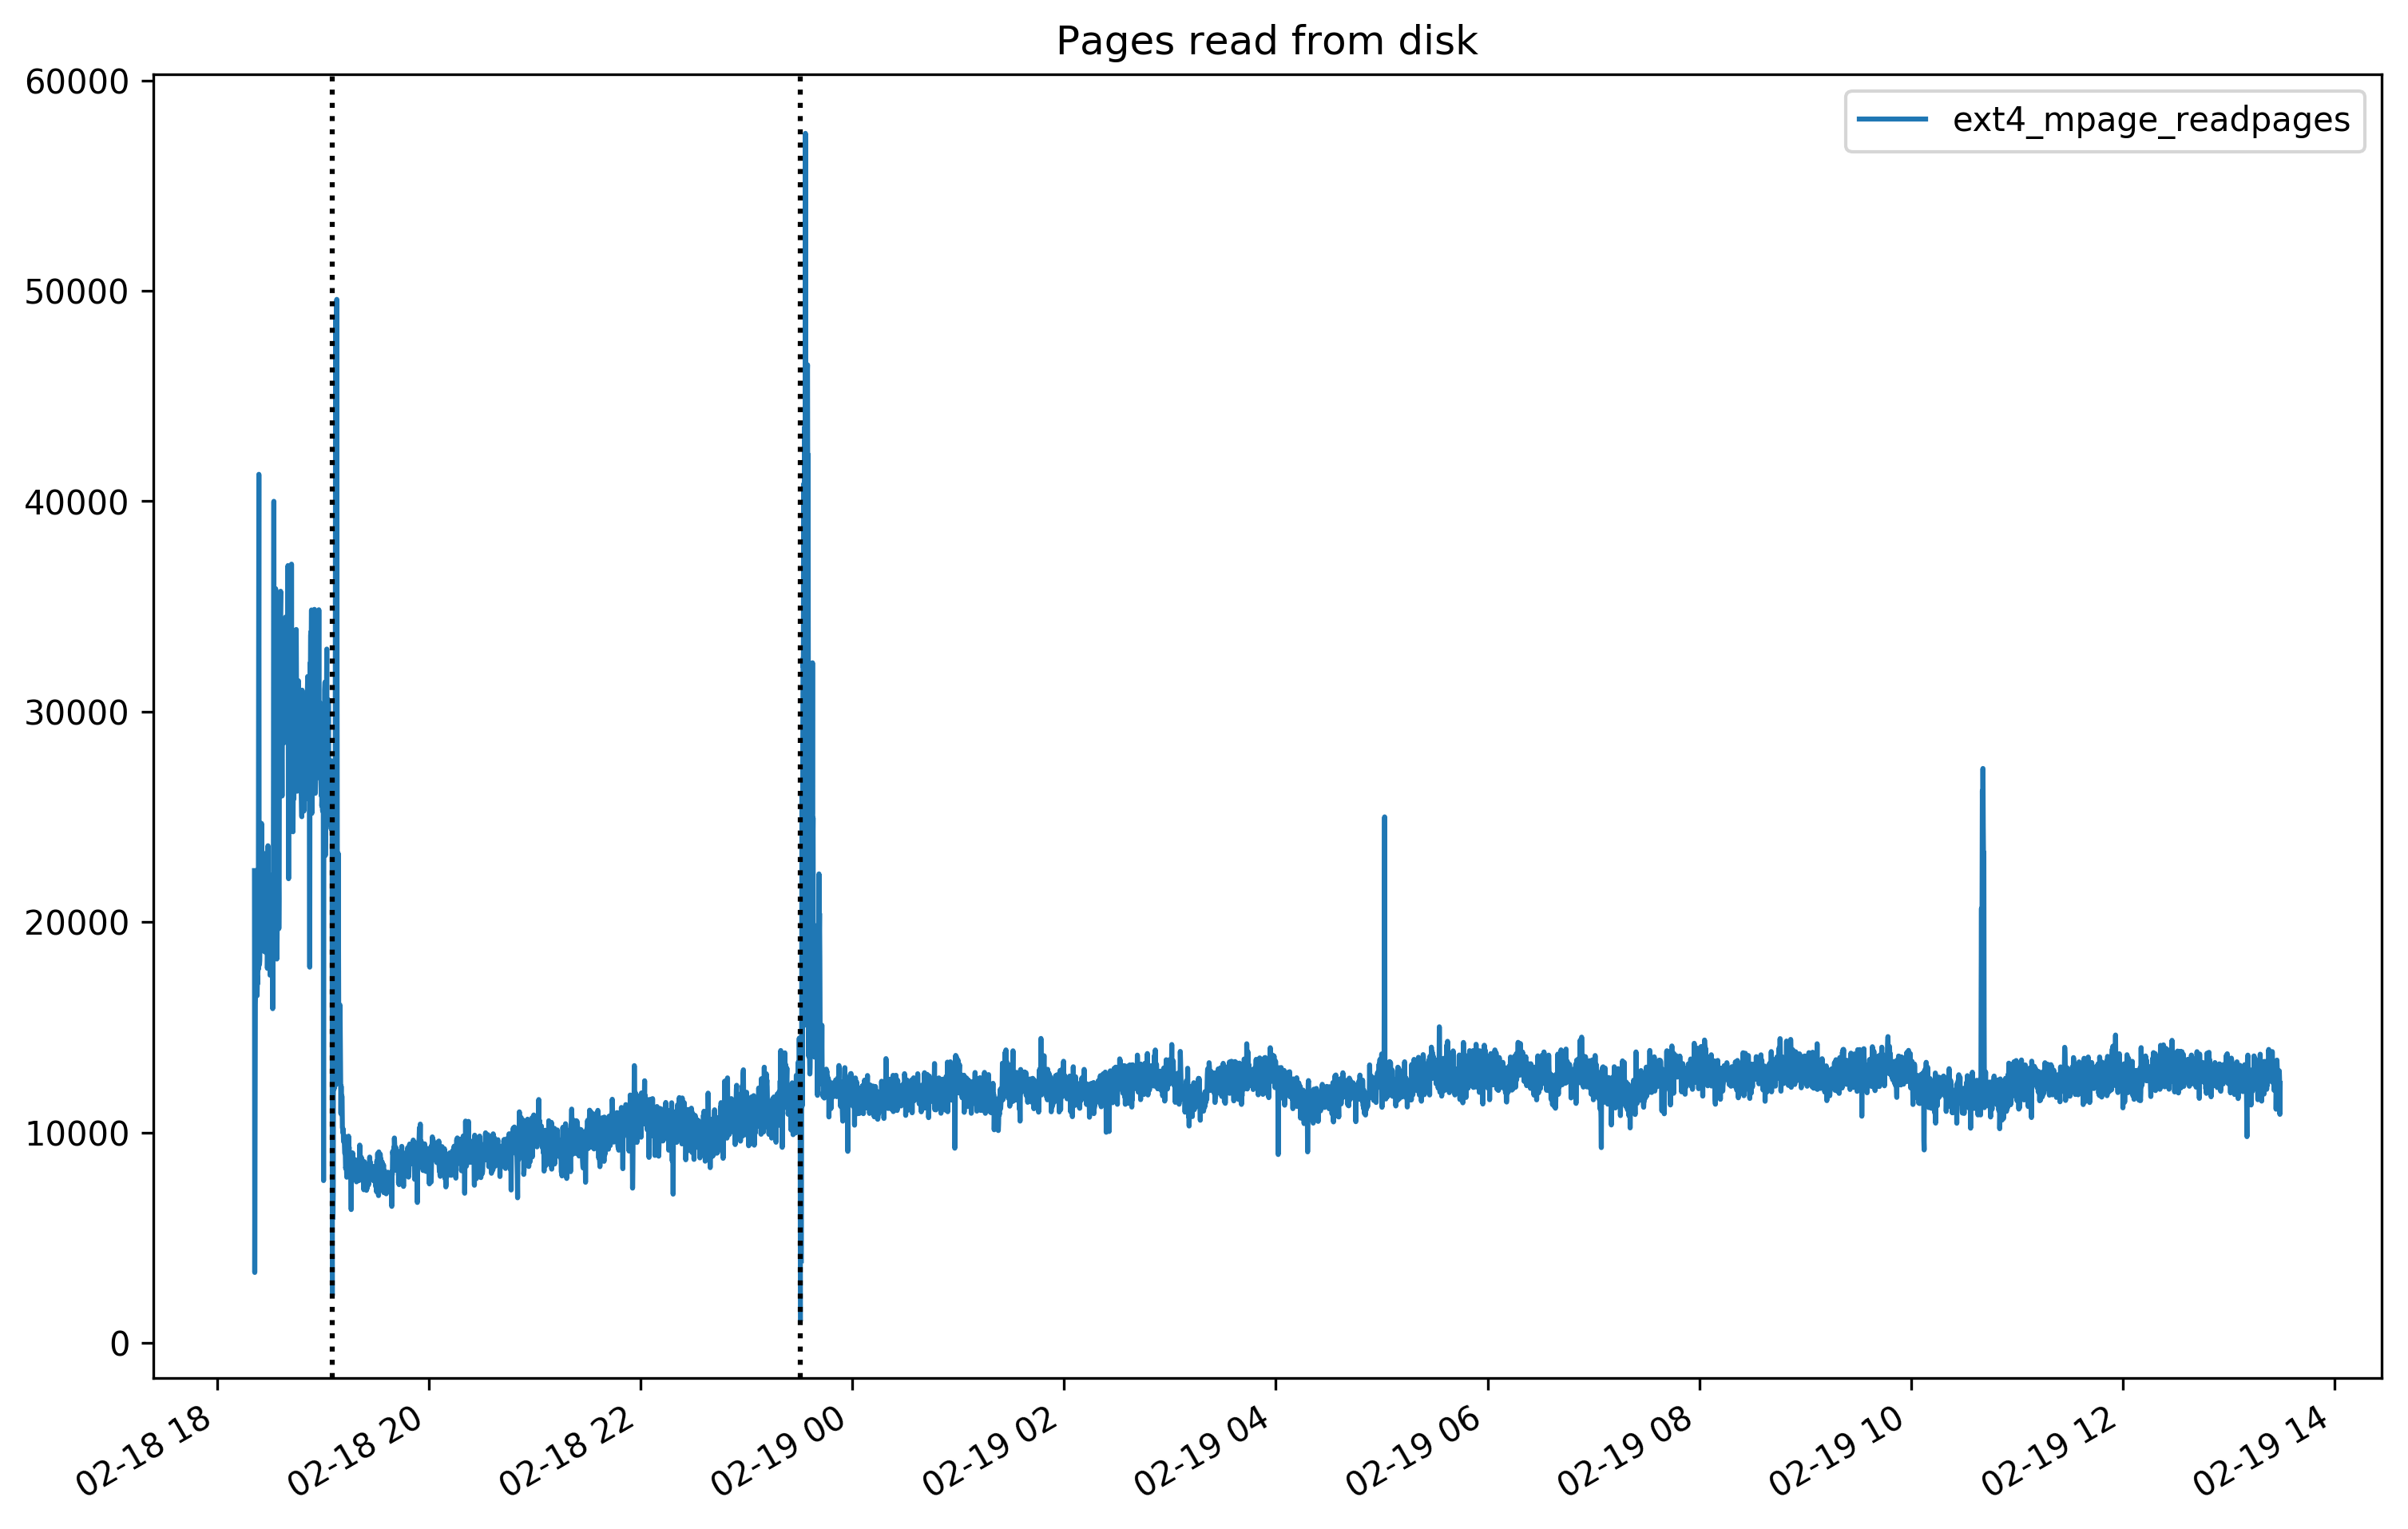

In [21]:
plot(select(bio, 'pages'), title='Pages read from disk')

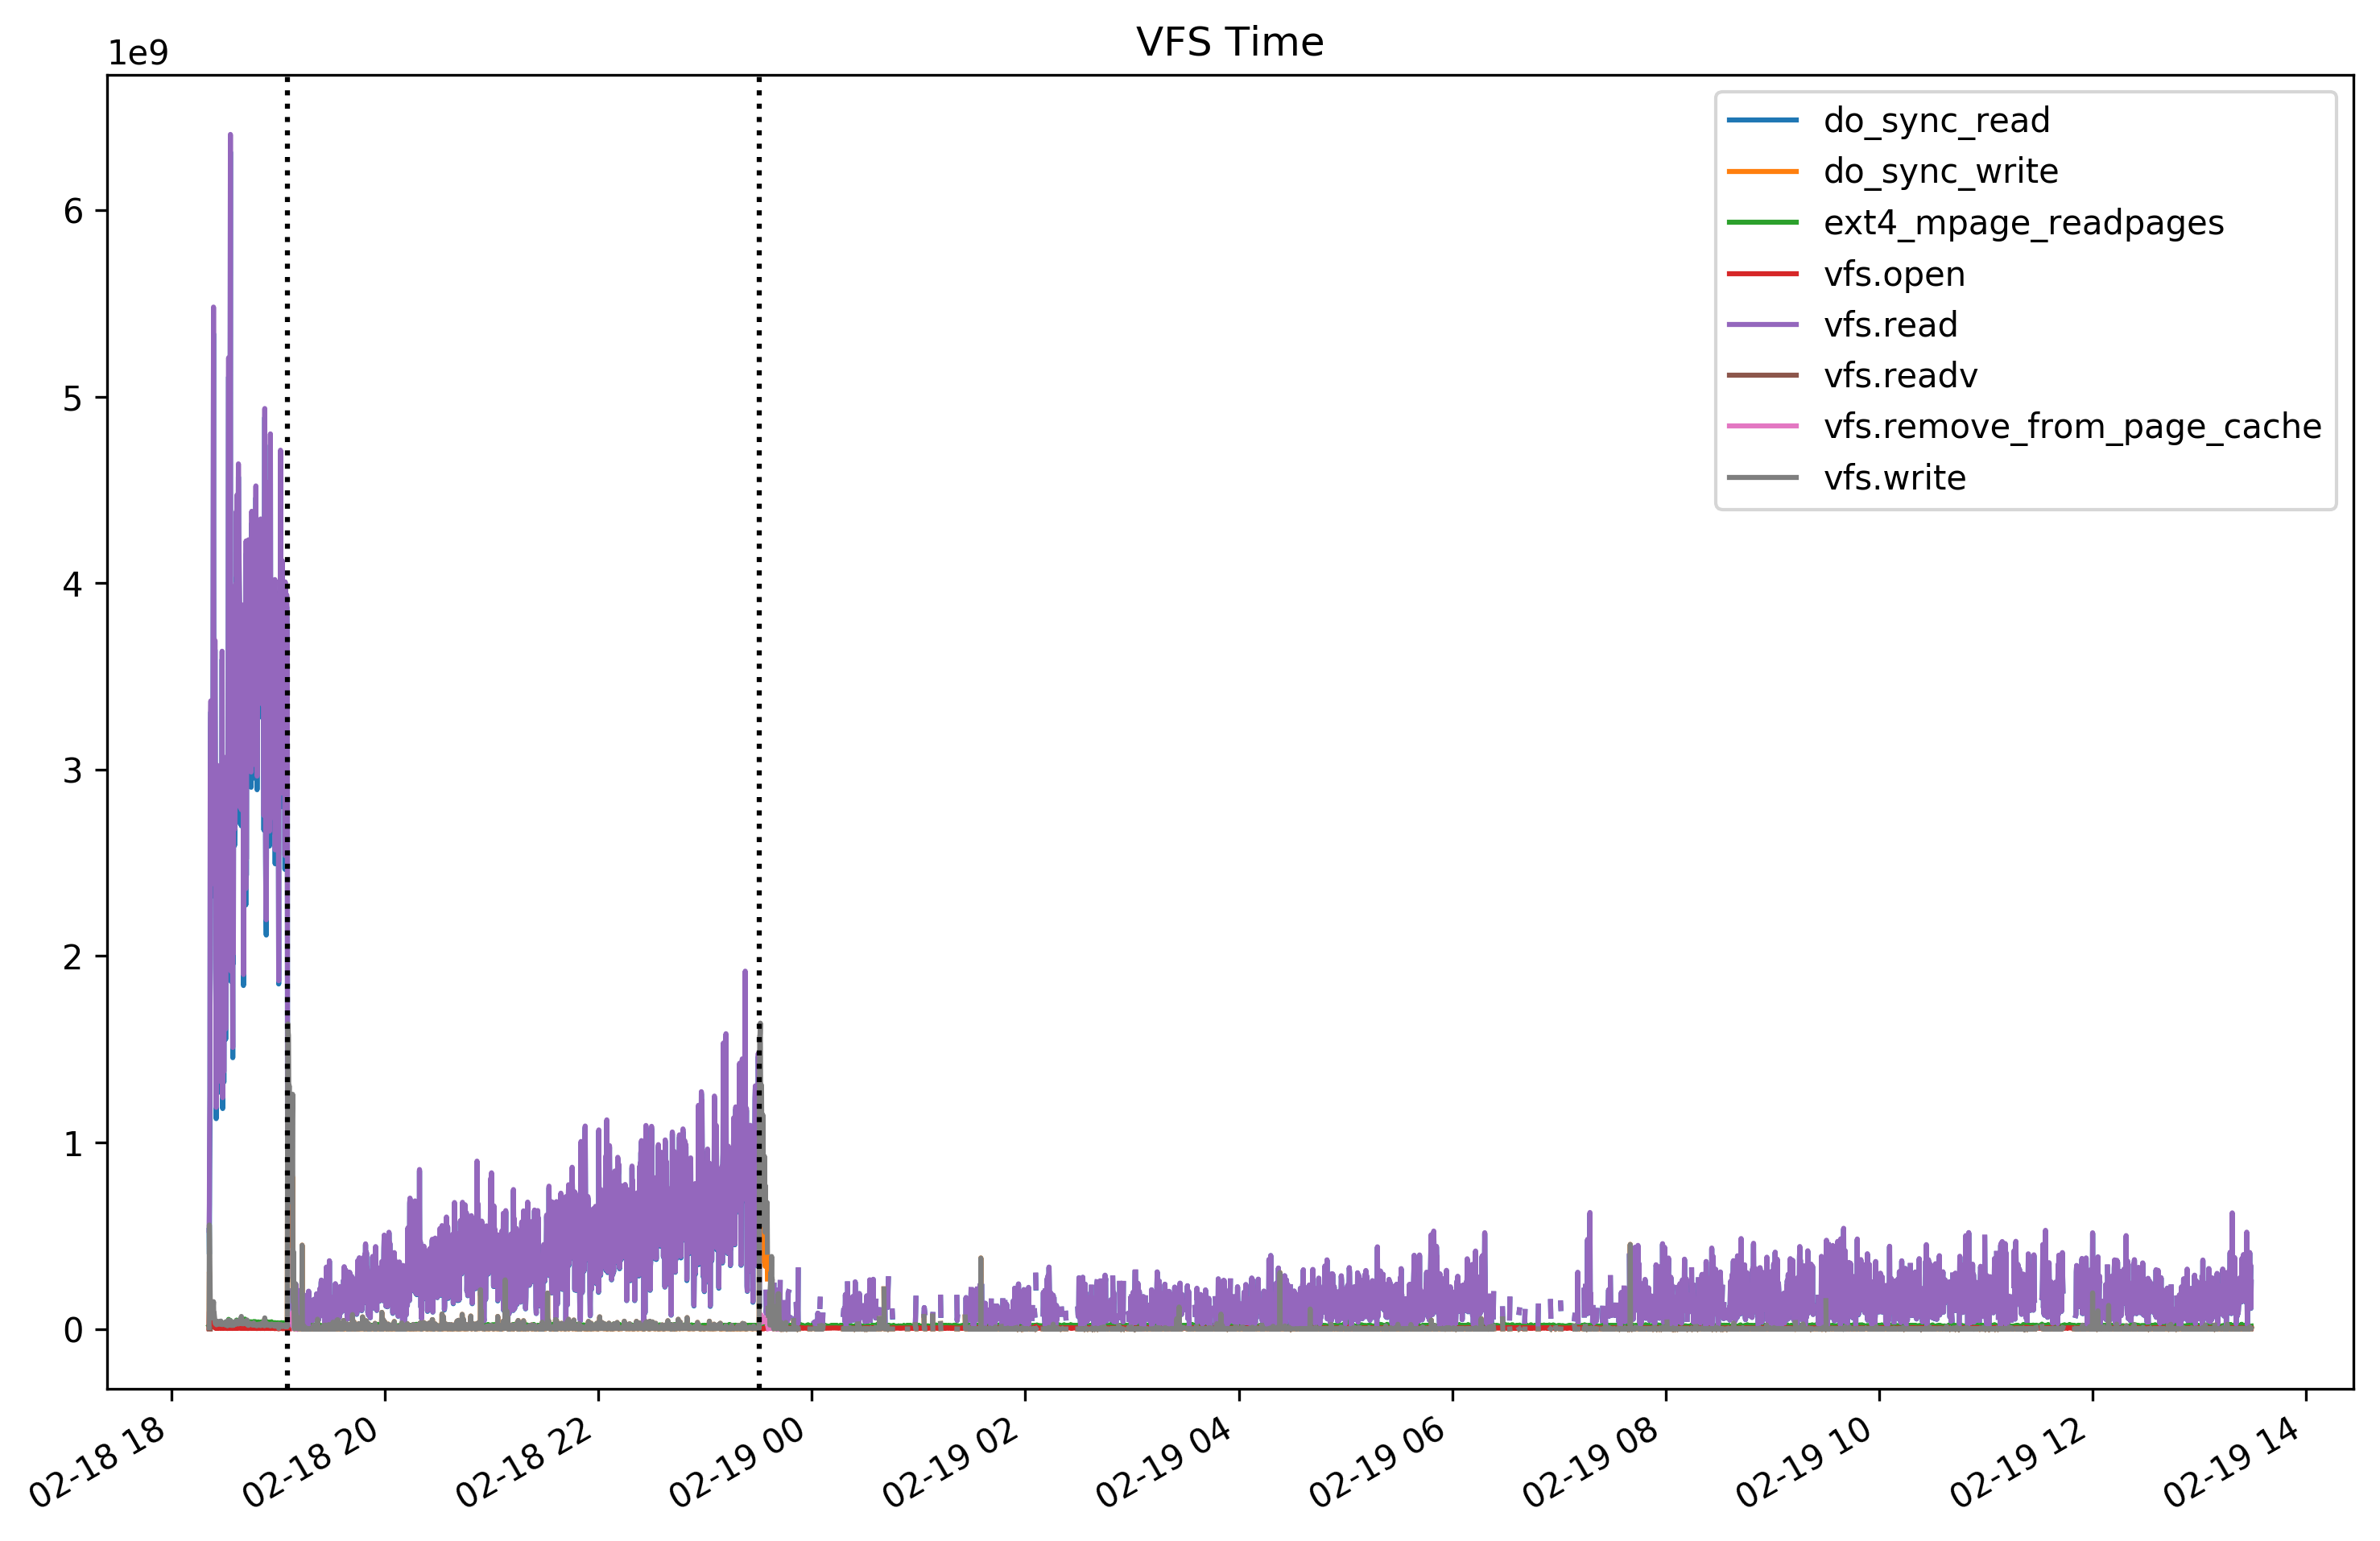

In [22]:
vfstime = select(vfs, 'time')
#vfstime[vfstime.columns] /= 1e9
plot(vfstime, title="VFS Time")

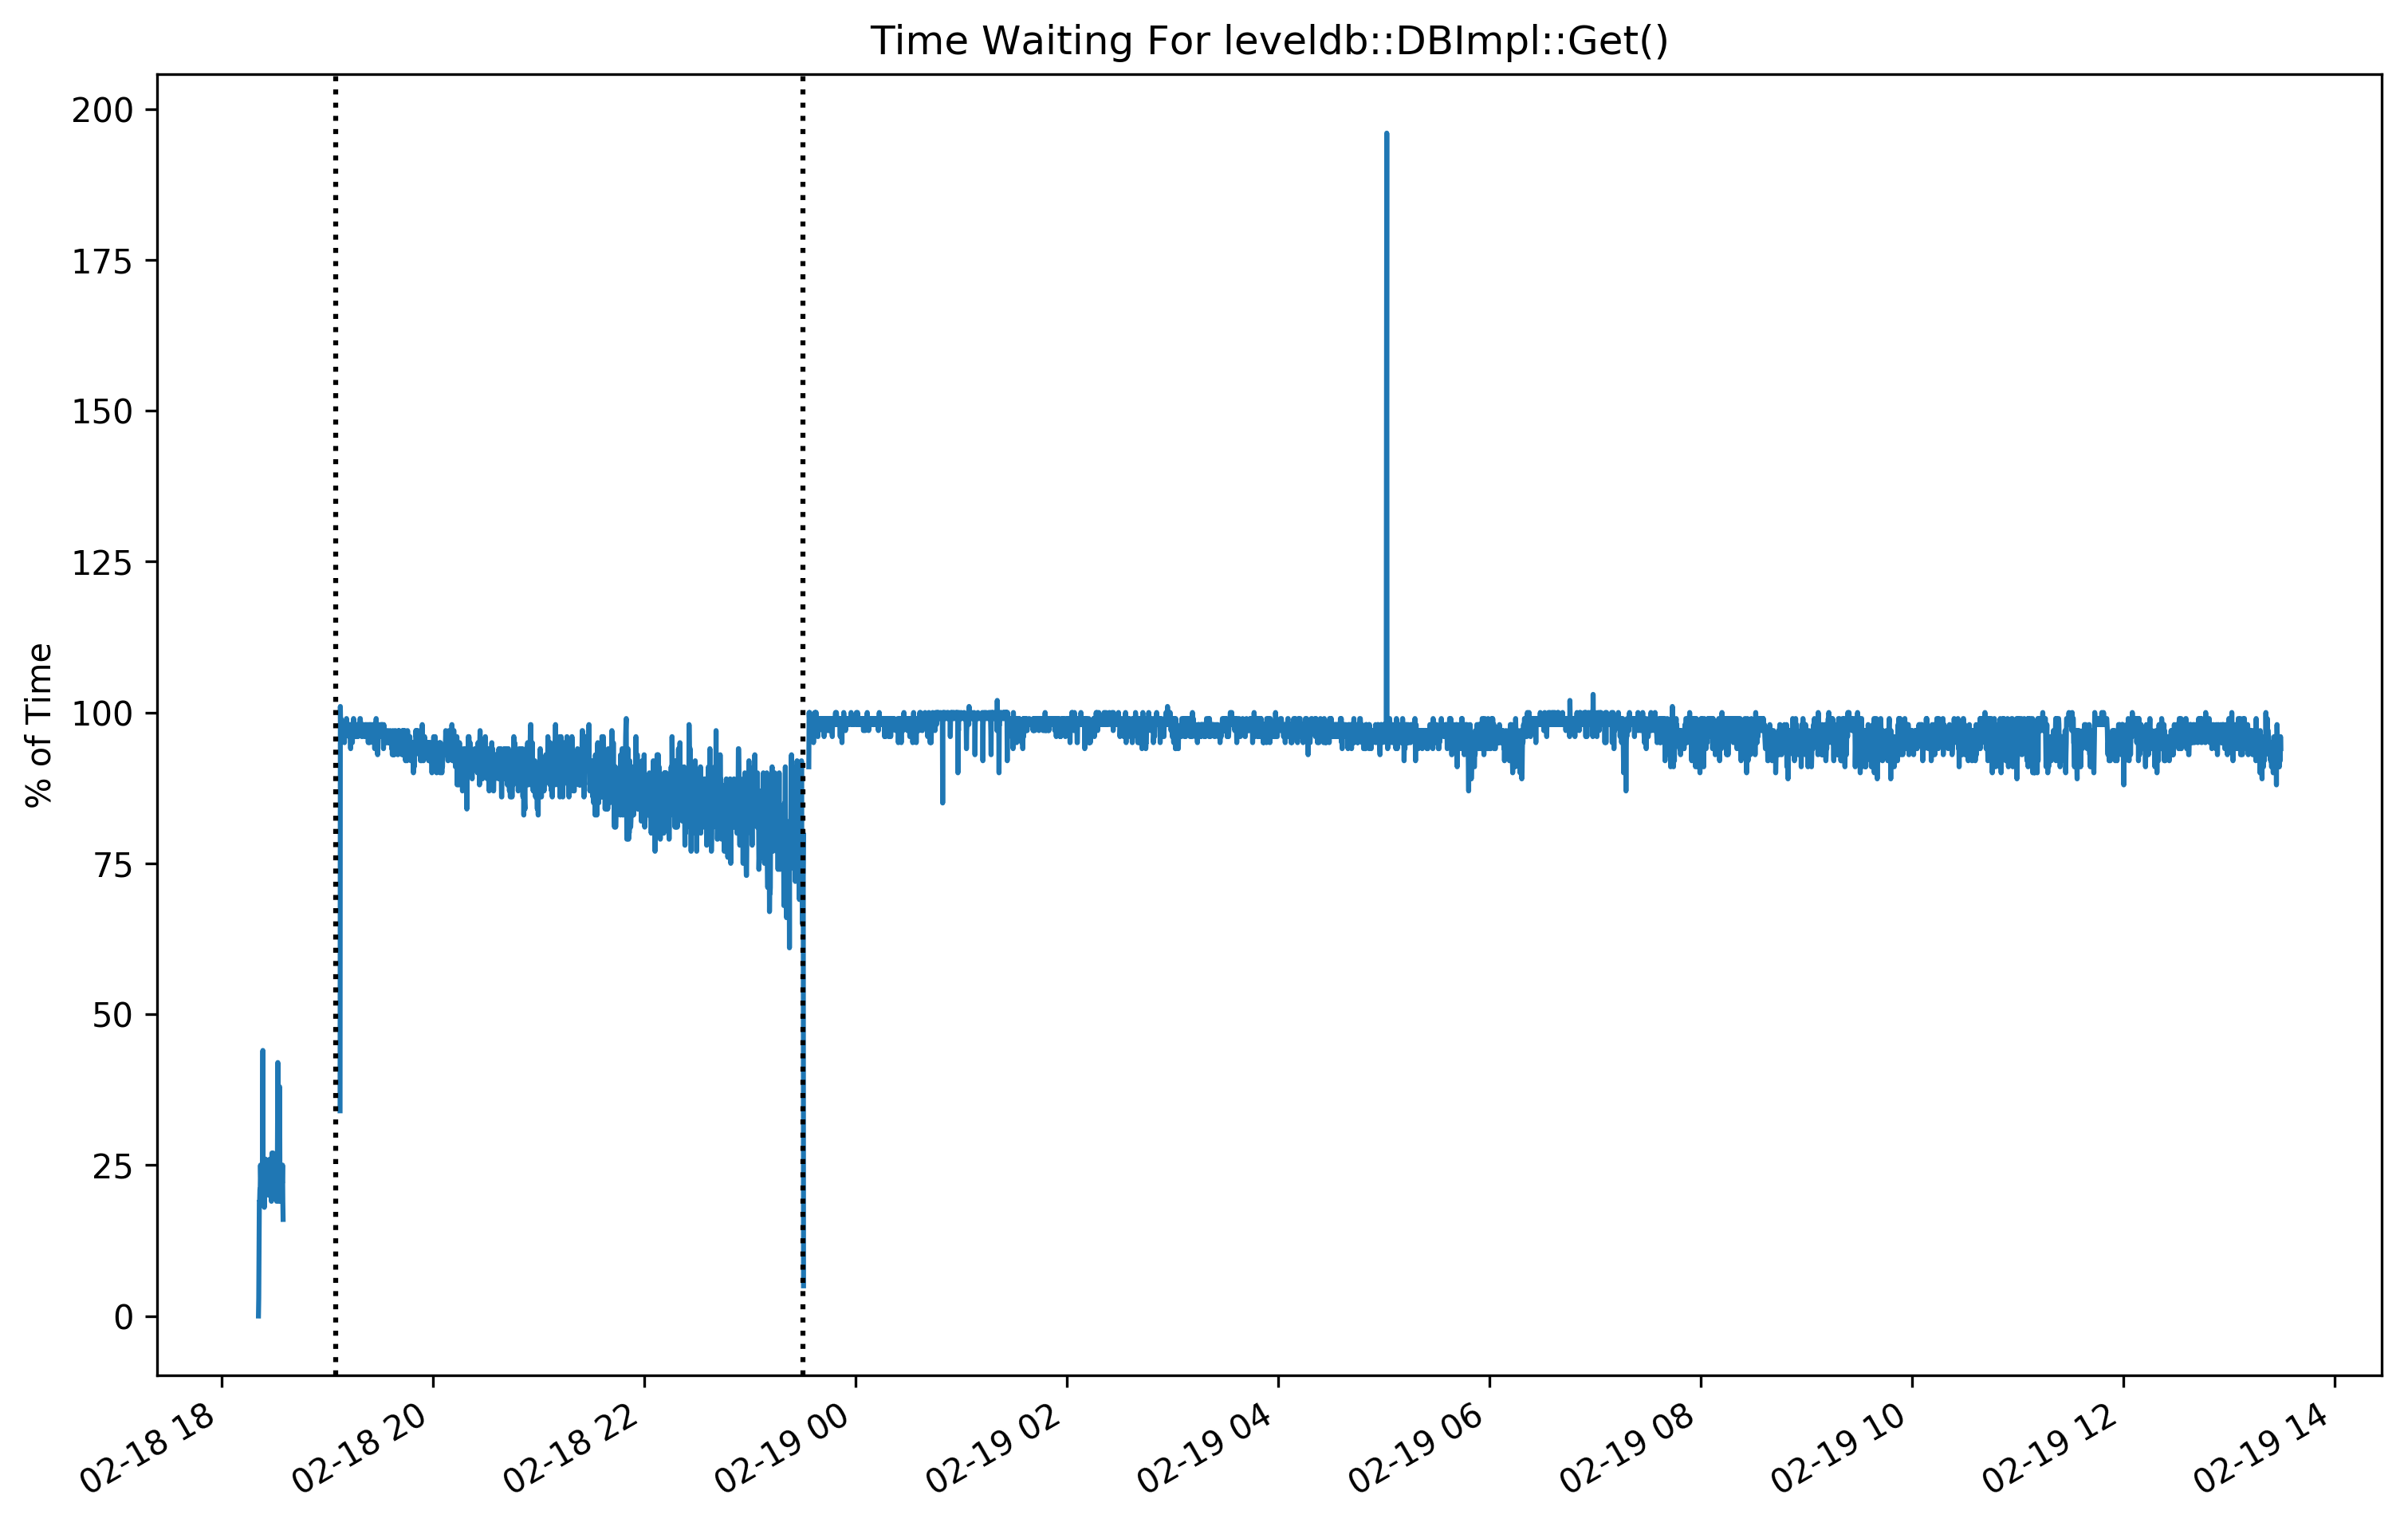

In [27]:
plot(leveldb['get:time']/1e8, title='Time Waiting For leveldb::DBImpl::Get()', ylabel='% of Time')

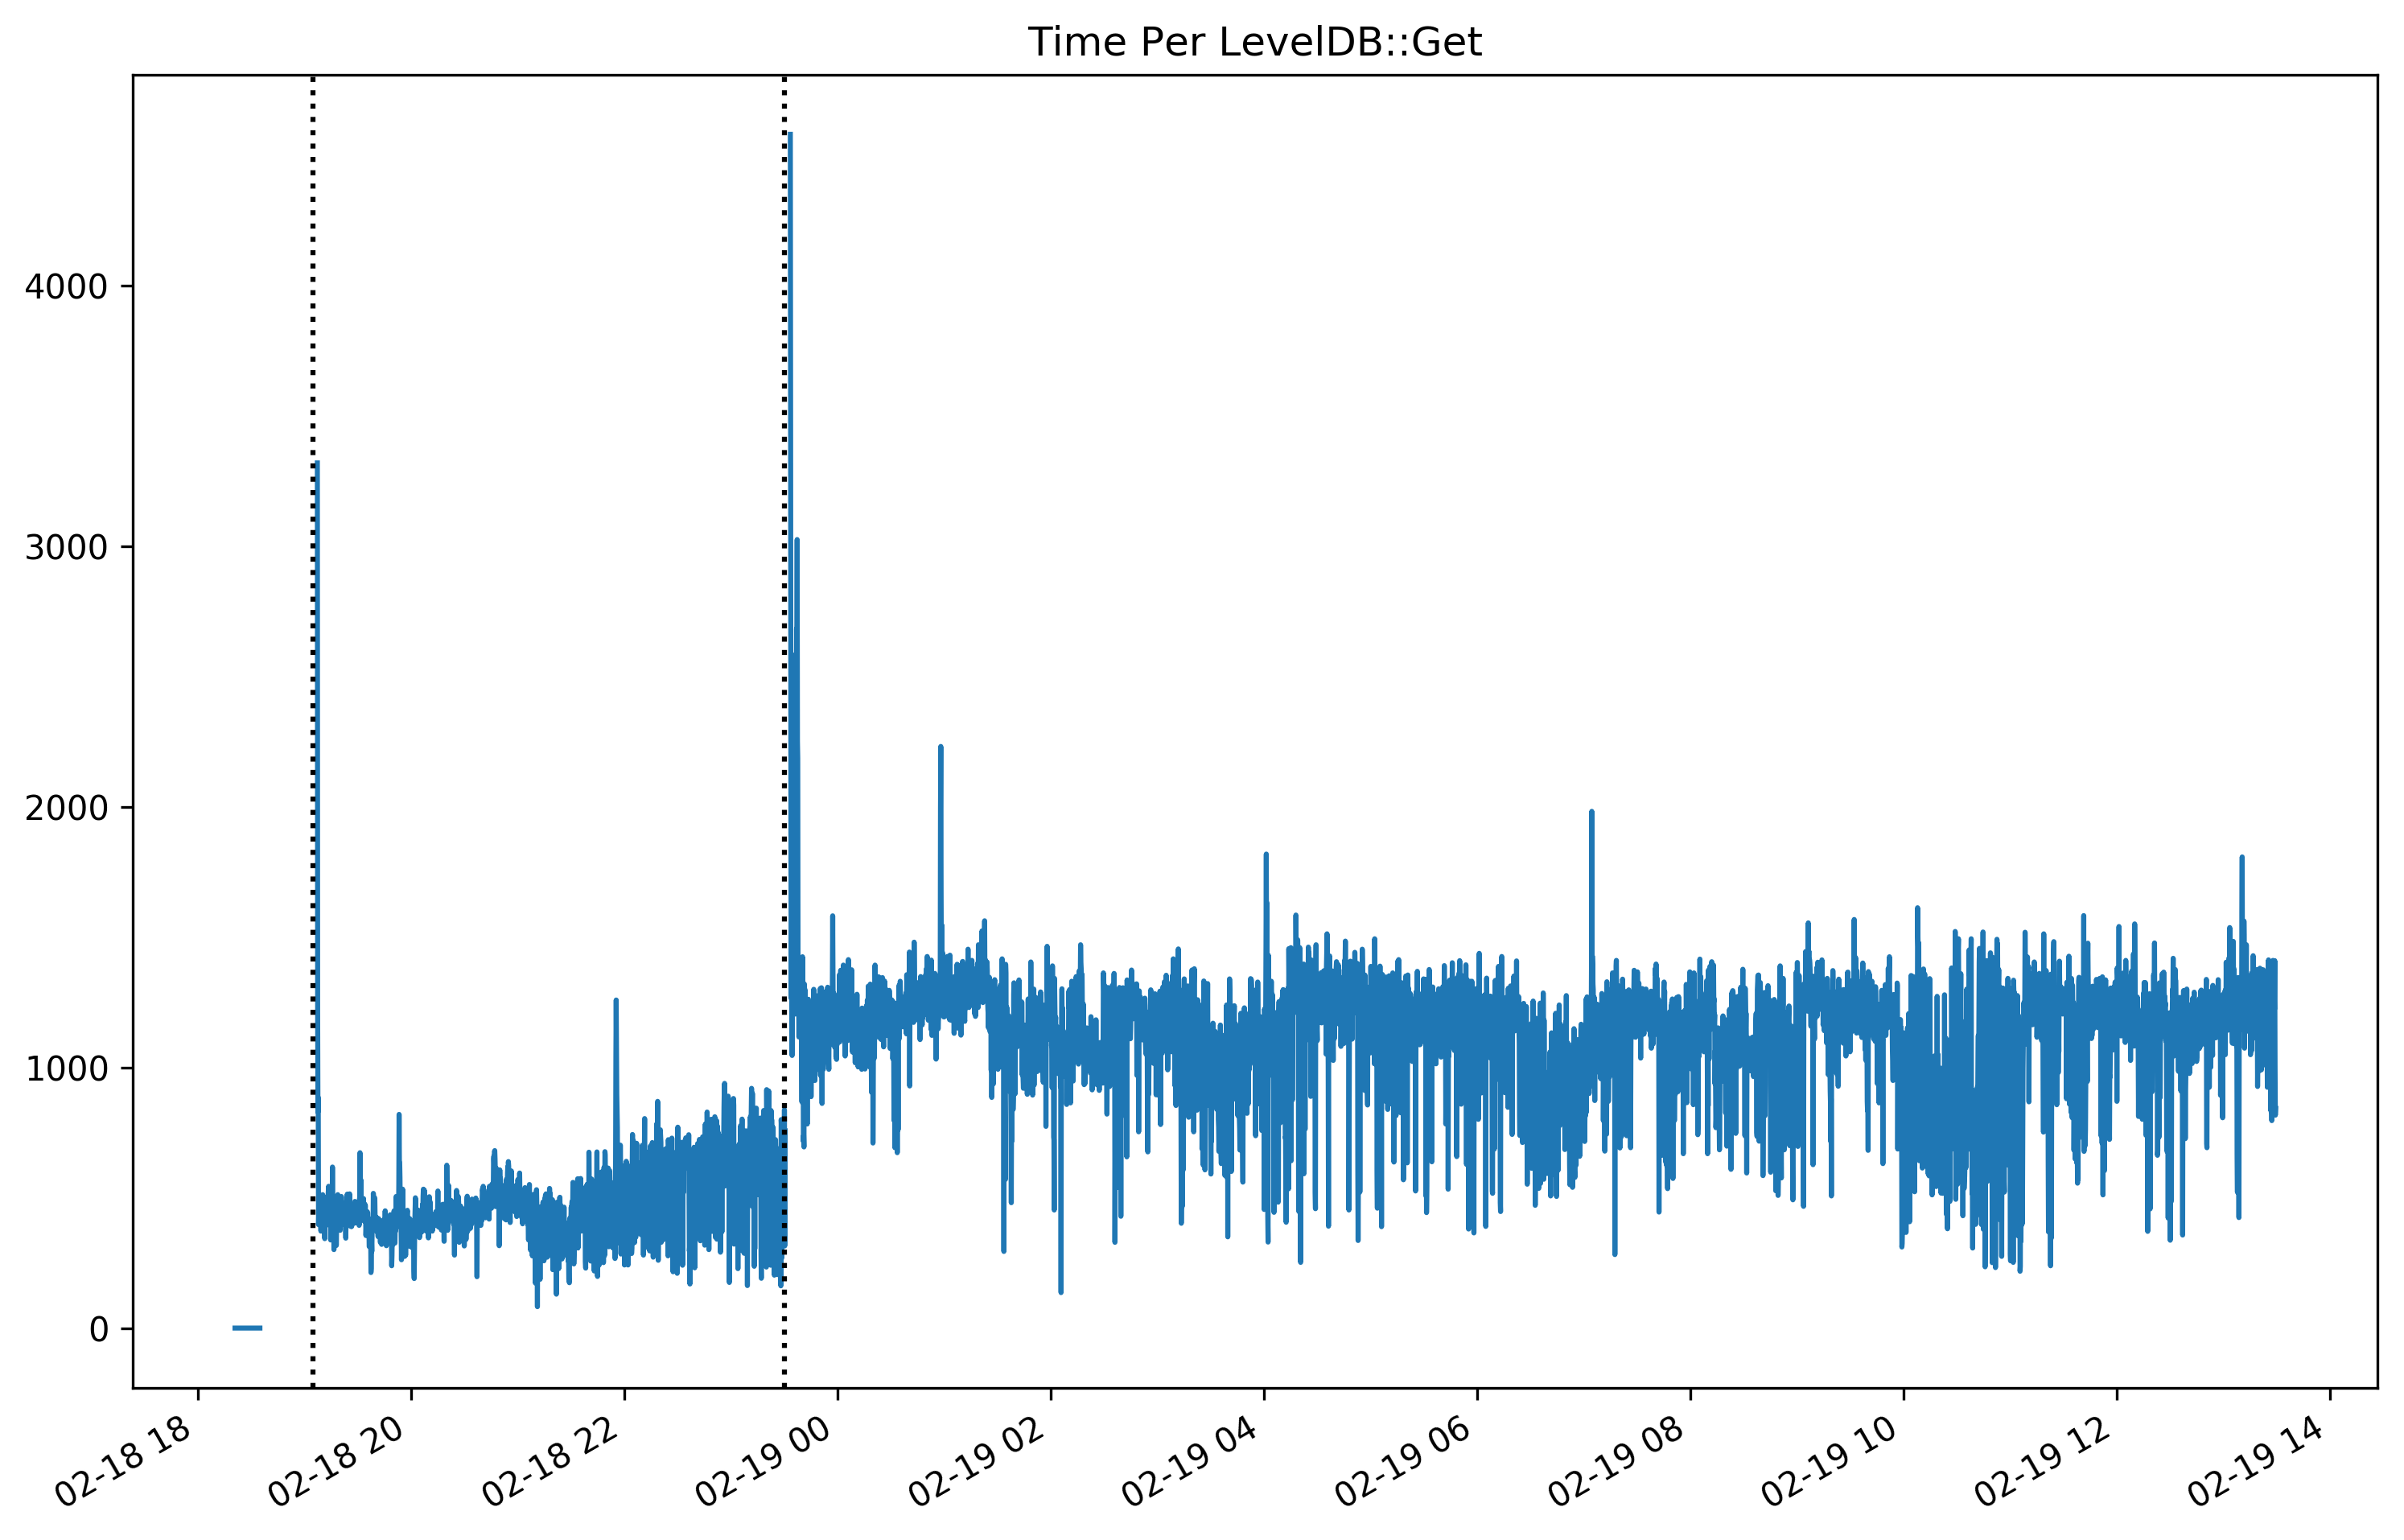

In [28]:
plot((leveldb['get:time']/1e4)/leveldb['get:count'], title='Time Per LevelDB::Get')